In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ls ./hourly_energy_cons/

AEP_hourly.csv*      DUQ_hourly.csv*      PJMW_hourly.csv*
COMED_hourly.csv*    EKPC_hourly.csv*     PJM_Load_hourly.csv*
DAYTON_hourly.csv*   FE_hourly.csv*       est_hourly.paruqet*
DEOK_hourly.csv*     NI_hourly.csv*       pjm_hourly_est.csv*
DOM_hourly.csv*      PJME_hourly.csv*


## About Dataset

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

<b>Dataset can be found in kaggle [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)</b>

In [3]:
# we are going to study the PJME dataset
plant = "PJME"
data = pd.read_csv(f'./hourly_energy_cons/{plant}_hourly.csv', parse_dates=True, index_col=[0])
data.rename(columns={f"{plant}_MW":'Power_Demand'}, inplace=True)

In [4]:
data.head()

,Power_Demand
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
data.shape

(145366, 1)

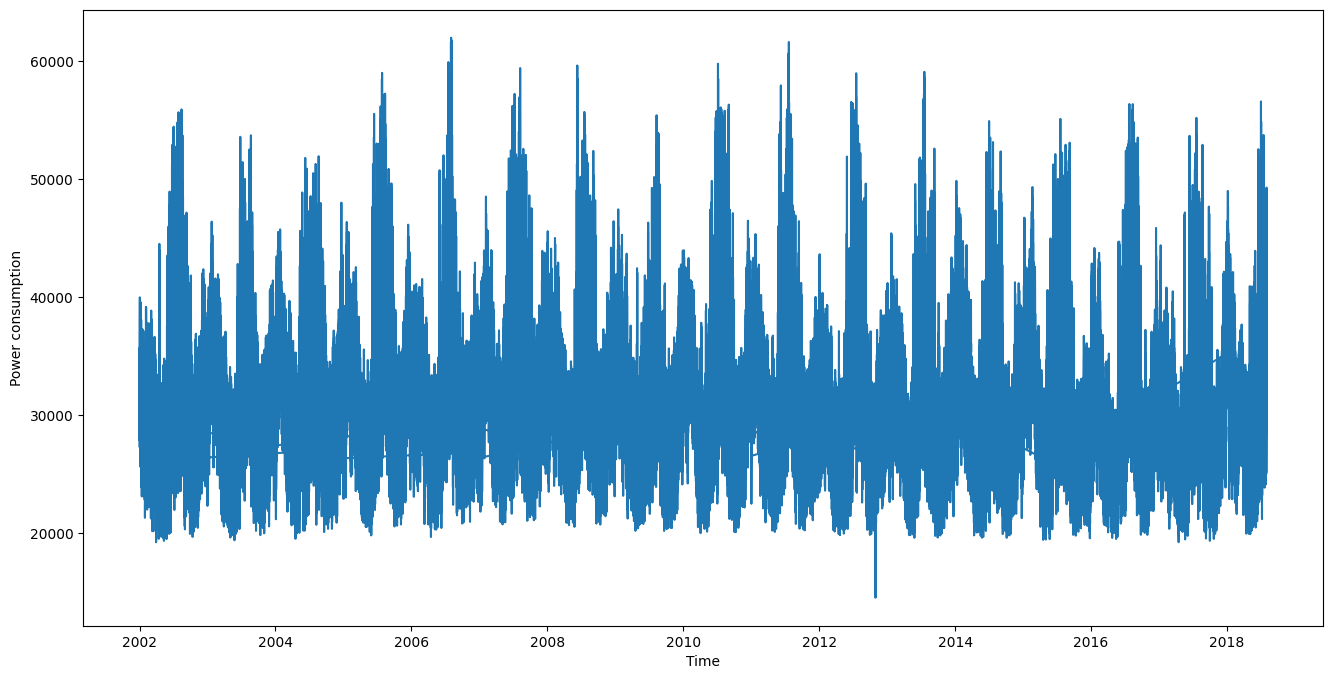

In [6]:
# Visualise the power consumption data
plt.figure(figsize=(16,8))
plt.plot(data["Power_Demand"])
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.show()

## Data cleaning

Before starting the data analysis, we will first check if the data contains nan values or duplicated datetimes and remove them if they exist.

Because we are dealing with an hourly based dataset we must also ensure that all recorded hours are present in the data, this can be done by checking the data time frequency (which should be in Hours).

In [7]:
# look for null/Nan instances in the data
data.isna().sum()

Power_Demand    0
dtype: int64

In [8]:
# Check for duplicated datetimes (index)
print(f"Duplicate count: {data.index.duplicated().sum()}")
# remove duplicates
data = data[~data.index.duplicated()]

Duplicate count: 4


In [9]:
# Check datetimes frequency
print(f"Data datetime frequency : {data.index.array.freq}")

Data datetime frequency : None


The fact that frequency is None means that there are missing datetimes, we can find those by comparing the original dataset datetimes with an hourly date range created for the same period.

In [10]:
dates = pd.to_datetime(data.index)
date_range = pd.date_range(start=min(dates), end=max(dates), freq='H')
print(f"Missing datetimes:\n{date_range.difference(dates.array)}")

Missing datetimes:
DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)


To handle those missing values, we must reindex the data with the full hourly date range. This will introduce null values to the power demand data, those can be filled using previous/next methods but to keep the continous aspect of the power demand data a linear interpolation is used instead.

In [11]:
data = data.reindex(date_range)
data['Power_Demand'].interpolate(method='linear', inplace=True)

In [12]:
# Check datetimes frequency again
print(f"Data datetime frequency : {data.index.array.freq}")

Data datetime frequency : <Hour>


## Data engineering

In order to use this data to train ML models (XGB, RF,...), we must first put it in the form of a supervised learning task (features/target). So from the datetimes values we will extract the following features: hour, day of week, quarter, month, year, day of year, day of month , week of year.

In [13]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['dayofmonth'] = data.index.day
data['dayofyear'] = data.index.dayofyear
data['quarter'] = data.index.quarter
data['month'] = data.index.month
data['year'] = data.index.year
data['weekofyear'] = data.index.isocalendar().week.astype("int")

data = data[['hour','dayofweek', 'dayofmonth','dayofyear', 'quarter',
             'month','year', 'weekofyear', "Power_Demand"]]

In [14]:
data.head()

,hour,dayofweek,dayofmonth,dayofyear,quarter,month,year,weekofyear,Power_Demand
2002-01-01 01:00:00,1,1,1,1,1,1,2002,1,30393.0
2002-01-01 02:00:00,2,1,1,1,1,1,2002,1,29265.0
2002-01-01 03:00:00,3,1,1,1,1,1,2002,1,28357.0
2002-01-01 04:00:00,4,1,1,1,1,1,2002,1,27899.0
2002-01-01 05:00:00,5,1,1,1,1,1,2002,1,28057.0


## EDA

<Axes: xlabel='month', ylabel='Power_Demand'>

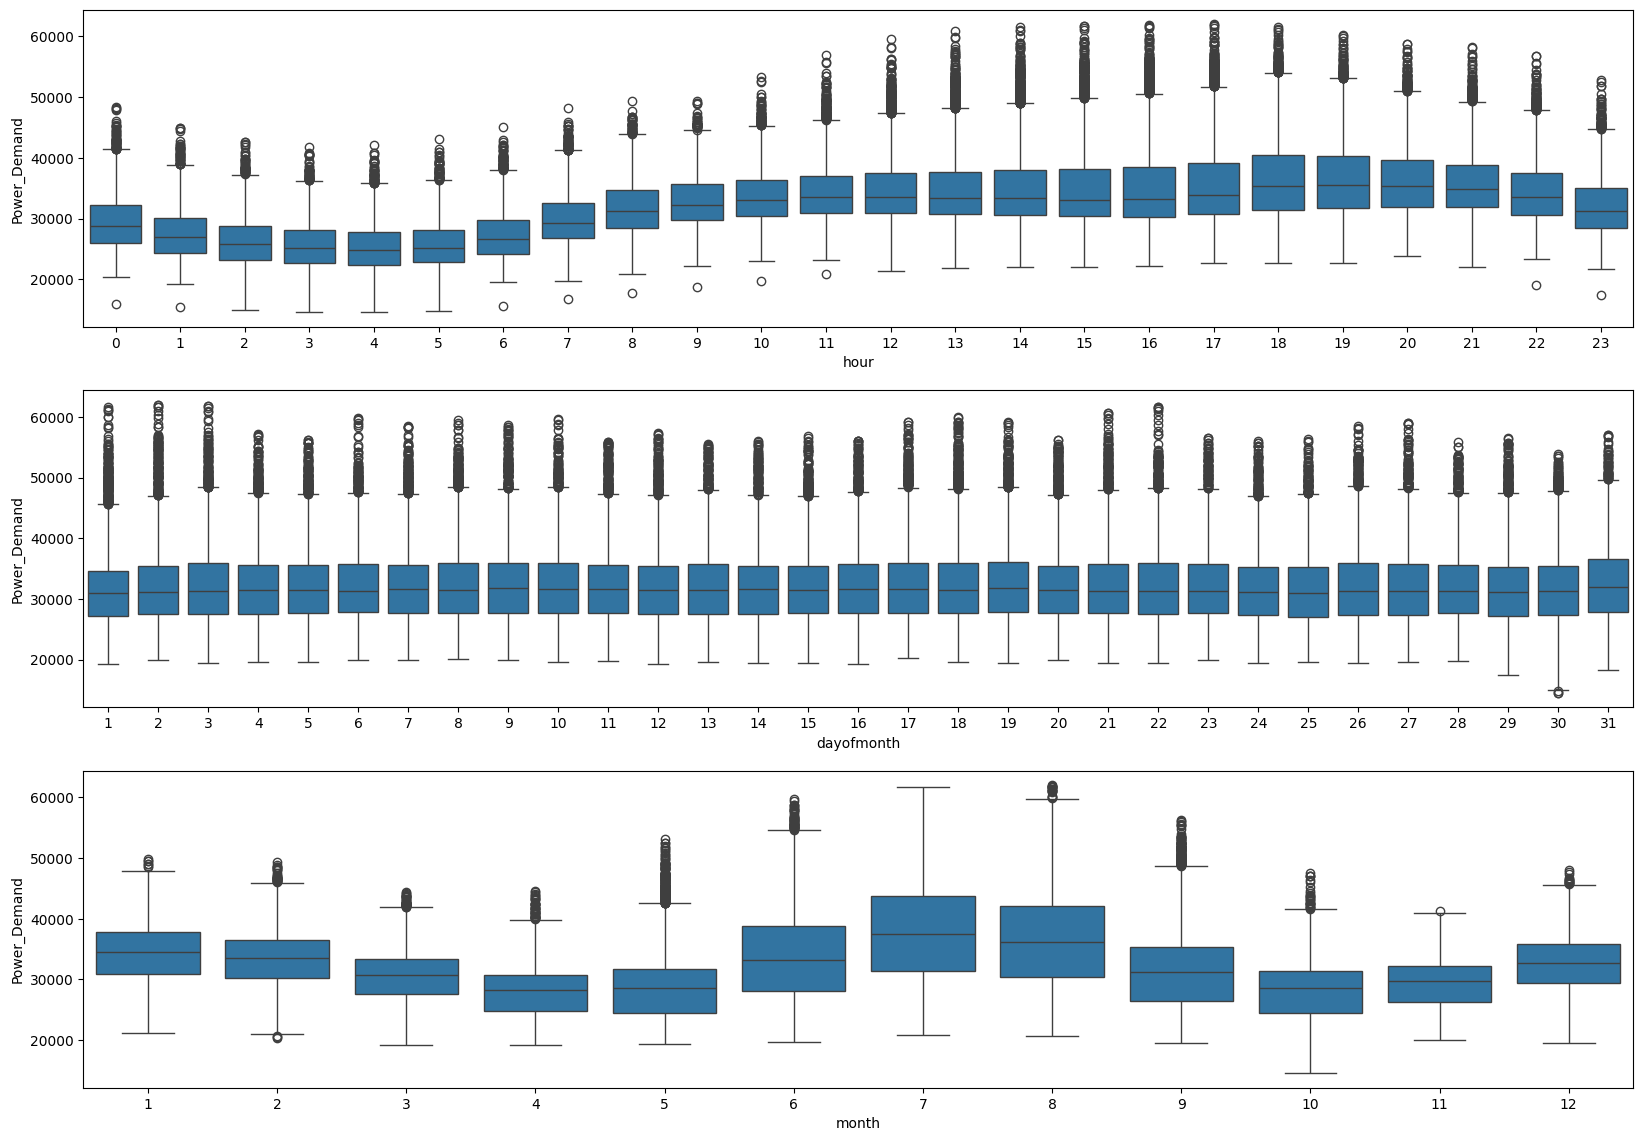

In [15]:
# plot hourly, daily and monthly power consumption
fig, axes = plt.subplots(3, figsize=(20, 14))
sns.boxplot(data, x="hour", y="Power_Demand", ax=axes[0])
sns.boxplot(data, x="dayofmonth", y="Power_Demand", ax=axes[1])
sns.boxplot(data, x="month", y="Power_Demand", ax=axes[2])

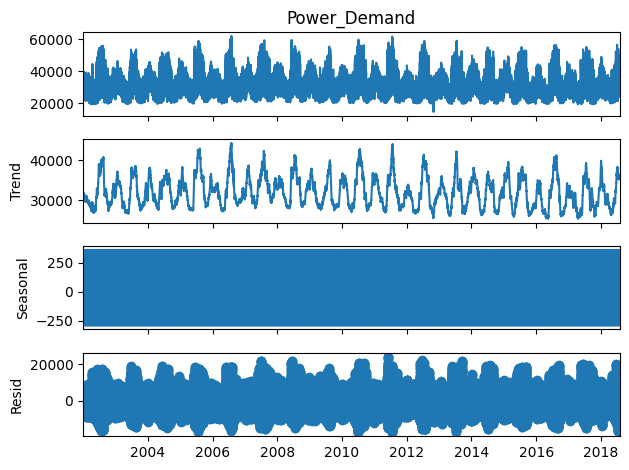

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# visualise the seasonality of the power consumption through the years
seasonal_decompose(data["Power_Demand"], period=365).plot()
plt.show()

From the above figures we can find that :

* The daily power consumption peak typically occurs between 5:00 PM and 8:00 PM, while the lowest demand is during the late-night hours from 2:00 AM to 5:00 AM. This observation aligns with logical expectations.

* The power consumption is at highest in during the summer months of June, July, and August.

* The power consumption data has a high seasonality component and shows a lot of variations through the years.

## Data Preprocessing

Before building the regression models, we will first perform a scaling of the power demand data to facilitate the learning of the models.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
target = scaler.fit_transform(data["Power_Demand"].values.reshape(-1,1))
data["Power_Demand"] = target

In [18]:
def split_data(data, split_date):
    train_data = data.loc[data.index <= split_date]
    test_data = data.loc[data.index > split_date]
    y_train = train_data['Power_Demand']
    x_train = train_data.drop(['Power_Demand'], axis=1)
    y_test = test_data['Power_Demand']
    x_test = test_data.drop(['Power_Demand'], axis=1)
    return x_train, y_train, x_test, y_test

In [19]:
split_date = "2017-06-01 00:00:00"
x_train, y_train, x_test, y_test = split_data(data.copy(), split_date)

<Axes: >

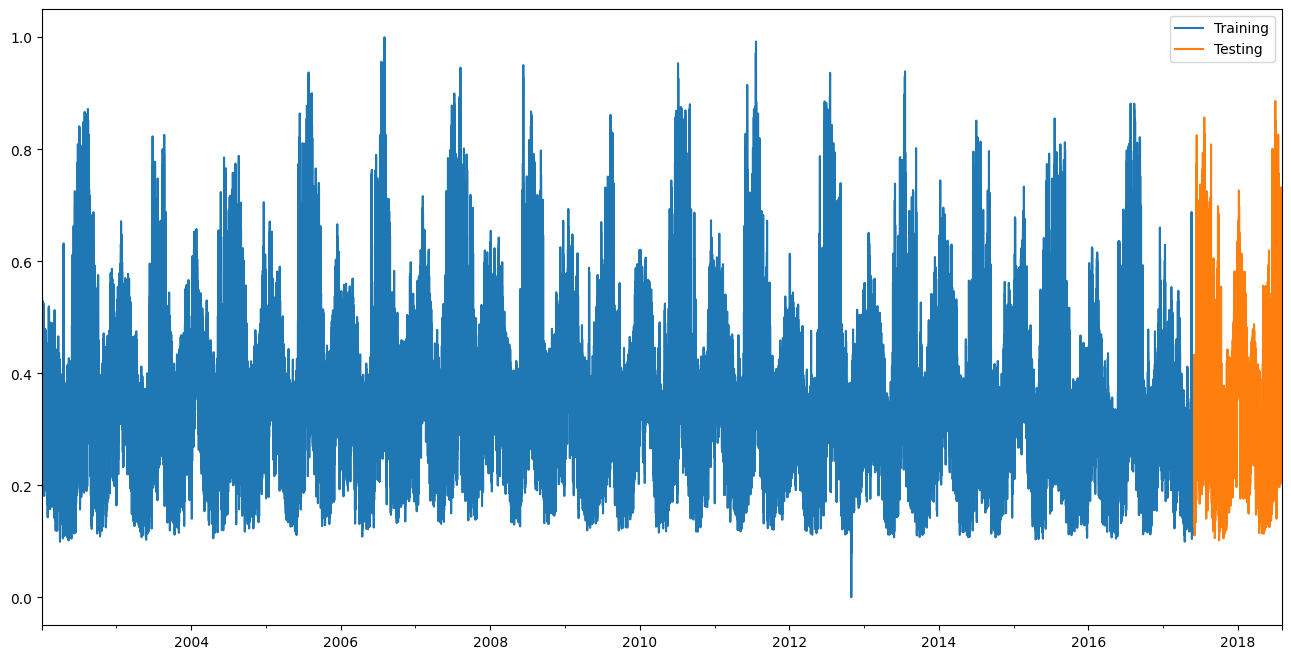

In [20]:
# Plot training and testing date splits
pd.DataFrame(y_train) \
    .rename(columns={'Power_Demand': 'Training'}) \
    .join(pd.DataFrame(y_test).rename(columns={'Power_Demand': 'Testing'}), how='outer') \
    .plot(figsize=(16,8))

## Building Models

### 1- XGBoost :

In [64]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)]) 

[0]	validation_0-rmse:0.18046	validation_1-rmse:0.18587
[1]	validation_0-rmse:0.17307	validation_1-rmse:0.17876
[2]	validation_0-rmse:0.16609	validation_1-rmse:0.17220
[3]	validation_0-rmse:0.15954	validation_1-rmse:0.16591
[4]	validation_0-rmse:0.15335	validation_1-rmse:0.16010
[5]	validation_0-rmse:0.14750	validation_1-rmse:0.15461
[6]	validation_0-rmse:0.14205	validation_1-rmse:0.14949
[7]	validation_0-rmse:0.13690	validation_1-rmse:0.14463
[8]	validation_0-rmse:0.13205	validation_1-rmse:0.14019
[9]	validation_0-rmse:0.12751	validation_1-rmse:0.13608
[10]	validation_0-rmse:0.12327	validation_1-rmse:0.13206
[11]	validation_0-rmse:0.11930	validation_1-rmse:0.12845
[12]	validation_0-rmse:0.11552	validation_1-rmse:0.12494
[13]	validation_0-rmse:0.11204	validation_1-rmse:0.12174
[14]	validation_0-rmse:0.10872	validation_1-rmse:0.11865
[15]	validation_0-rmse:0.10564	validation_1-rmse:0.11580
[16]	validation_0-rmse:0.10278	validation_1-rmse:0.11307
[17]	validation_0-rmse:0.10013	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

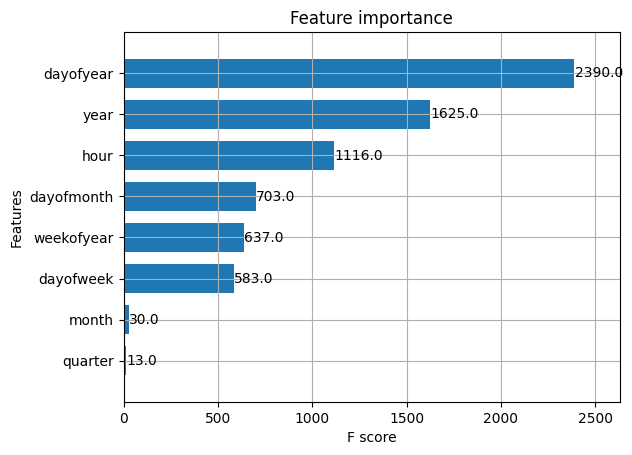

In [65]:
_ = xgb.plot_importance(reg, height=0.7)

In [66]:
test = pd.concat([y_test, pd.Series(reg.predict(x_test), index=y_test.index)], axis=1)
test.columns = ["Power_Demand", "Predicted demand"]

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute the accuracy errors : MAE, MSE, RMSE, MAPE, R2 score.
def get_prediction_errors(y_true, y_pred):
    print(f"R2 score: {r2_score(y_true, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)}")
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [68]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16,8))
    plt.plot(test, label='Actual power consumption')
    plt.plot(predicted, alpha=0.7, label='Predicted power consumption')
    plt.xlabel('Time')
    plt.ylabel('Power consumption')
    plt.legend()
    plt.show()

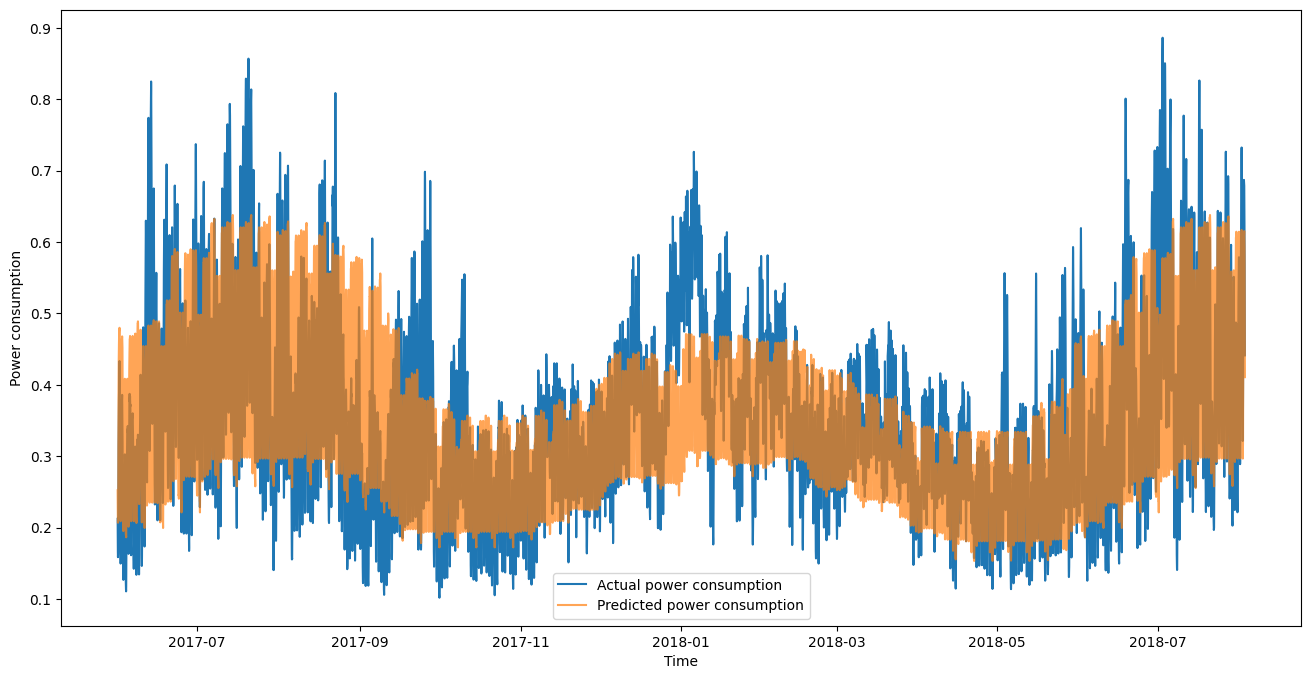

In [69]:
plot_predictions(test["Power_Demand"], test["Predicted demand"])

In [70]:
get_prediction_errors(y_true=test["Power_Demand"], y_pred=test["Predicted demand"])

R2 score: 0.6305757209331382
MAE: 0.06205624487167076
MSE: 0.006786889047145111
RMSE: 0.08238257732764319
MAPE: 18.308404595878958


### 2- Random Forest Regressor :

In [73]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200)

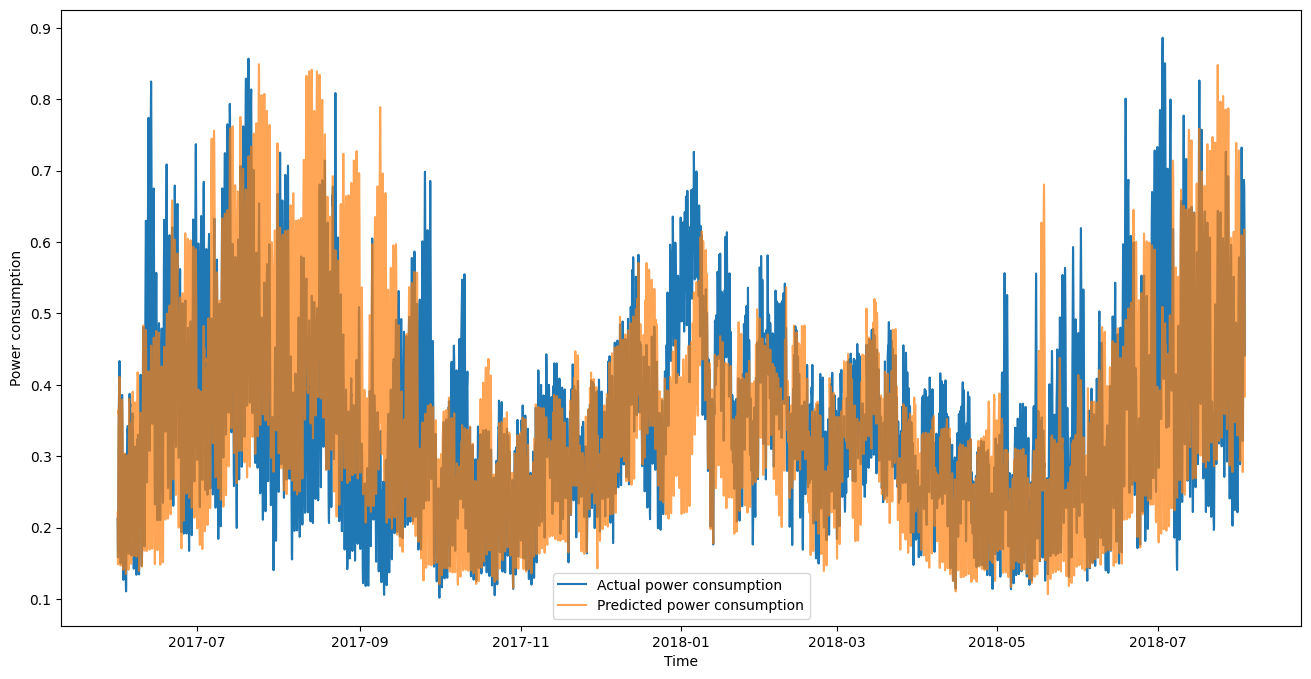

In [74]:
test["Predicted demand"] = rf.predict(x_test)
plot_predictions(test["Power_Demand"], test["Predicted demand"])

In [76]:
get_prediction_errors(y_true=np.array(test["Power_Demand"]), y_pred=test["Predicted demand"])

R2 score: 0.42632489169841004
MAE: 0.07397146323262296
MSE: 0.01053928918528706
RMSE: 0.10266104025036499
MAPE: 20.458368369882592


### 3- Neural Network LSTM :

In this part we will try to use neural networks to make the prediction, since future power consumption is significantly correlated with the past consumption, we will use the recurrent networks to take advantage of that and we will specificaly focus on the Long Short-Term Memory networks (LSTMs).

To train the LSTM network for our prediction we need to transform the power consumption data into a windowed structure. Each window will encompass a sequence of power consumption data, typically spanning 20 consecutive hours. The target for prediction will be the value immediately following the window, which corresponds to the 21st hour in our example.

In [21]:
def create_window_data(data, window_len, split_index):
    X = []
    Y = []
    for i in range(window_len, len(data)):
        X.append(data[i - window_len: i])
        Y.append(data[i])
    
    X_train = np.array(X[: split_index])
    y_train = np.array(Y[: split_index])
    X_test = np.array(X[split_index:])
    y_test = np.array(Y[split_index:])
    
    X_train = np.reshape(X_train, (X_train.shape[0], window_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], window_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [22]:
window_len = 20
split_index = list(data.index.astype("str")).index(split_date)
X_train, Y_train, X_test, Y_test = create_window_data(data["Power_Demand"], window_len, split_index)

In [23]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

lstm_model = Sequential()
lstm_model.add(LSTM(128, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(64, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1))
lstm_model.summary()

2023-10-02 15:03:22.812194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 15:03:30.584749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [25]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, Y_train, epochs=10, batch_size=1000)

Epoch 1/10
136/136 [==============================] - 88s 592ms/step - loss: 0.0170
Epoch 2/10
136/136 [==============================] - 81s 594ms/step - loss: 0.0051
Epoch 3/10
136/136 [==============================] - 81s 597ms/step - loss: 0.0022
Epoch 4/10
136/136 [==============================] - 82s 600ms/step - loss: 0.0013
Epoch 5/10
136/136 [==============================] - 89s 652ms/step - loss: 9.9277e-04
Epoch 6/10
136/136 [==============================] - 81s 598ms/step - loss: 8.5295e-04
Epoch 7/10
136/136 [==============================] - 81s 599ms/step - loss: 7.2974e-04
Epoch 8/10
136/136 [==============================] - 81s 598ms/step - loss: 6.7029e-04
Epoch 9/10
136/136 [==============================] - 81s 598ms/step - loss: 6.2535e-04
Epoch 10/10
136/136 [==============================] - 82s 600ms/step - loss: 5.8966e-04


<Axes: >

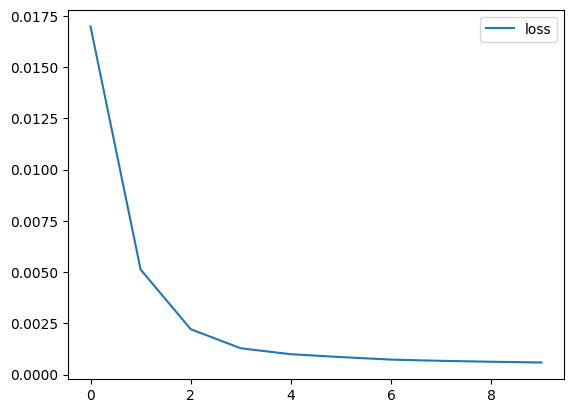

In [26]:
results = pd.DataFrame(lstm_model.history.history)
results.plot()

In [34]:
lstm_predictions = lstm_model.predict(X_test)
get_prediction_errors(Y_test, lstm_predictions)

321/321 [==============================] - 6s 18ms/step
R2 score: 0.9931930522771021
MAE: 0.008645056724030164
MSE: 0.00012512434117238042
RMSE: 0.011185899211613719
MAPE: 47.34109286639749


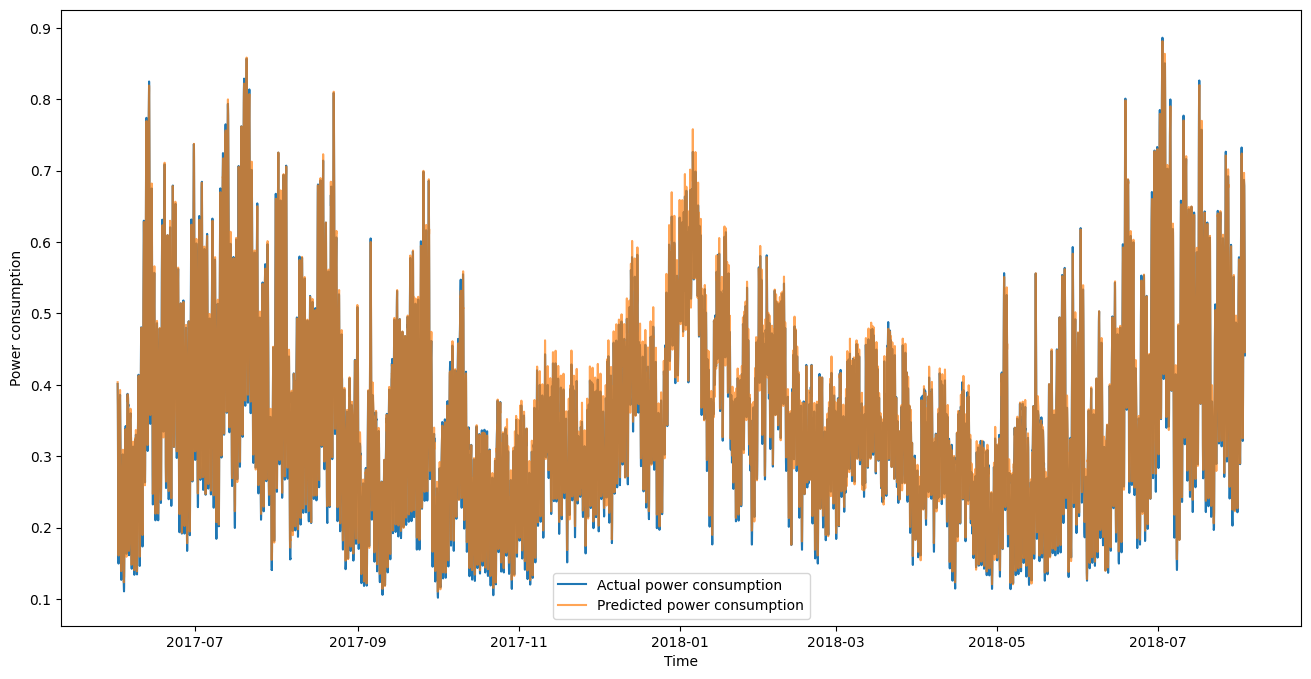

In [35]:
y_index = data.index[split_index+window_len:]
y_true = pd.DataFrame(Y_test, index=y_index)
y_pred = pd.DataFrame(lstm_predictions, index=y_index)
plot_predictions(y_true, y_pred)

## Future 7 day prediction

Using the trained models we will try to predict the next 7 days power consumption (without having the real consumption data to compare with).

In [54]:
def create_future_days_data(start_date, period):
    date_range = pd.date_range(start=start_date, periods=period, freq='h')
    future_days = pd.DataFrame({'Date': date_range})
    future_days.index = future_days["Date"]
    future_days['hour'] = future_days.index.hour
    future_days['dayofweek'] = future_days.index.dayofweek
    future_days['dayofmonth'] = future_days.index.day
    future_days['dayofyear'] = future_days.index.dayofyear
    future_days['quarter'] = future_days.index.quarter
    future_days['month'] = future_days.index.month
    future_days['year'] = future_days.index.year
    future_days['weekofyear'] = future_days.index.isocalendar().week.astype("int")
    future_days = future_days.drop(["Date"], axis=1)

    future_days = future_days[['hour','dayofweek','dayofmonth', 'dayofyear',
                               'quarter','month','year','weekofyear']]
    return future_days

In [55]:
start_date = '2018-08-03 00:00:00'  
period = 7 * 24 # 7 days

### 1- XGBoost :

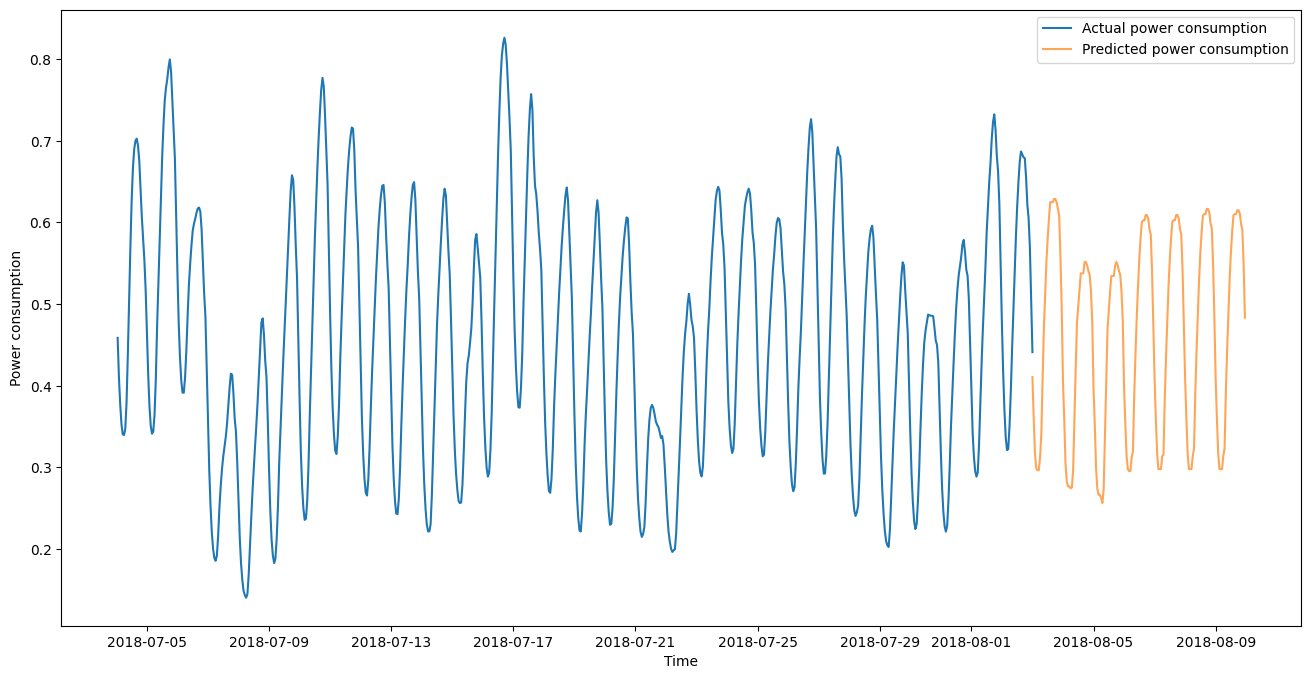

In [72]:
future_df = create_future_days_data(start_date, period)
future_prediction = reg.predict(future_df)
future_df["Power_Demand"] = future_prediction
plot_predictions(y_test.iloc[-24*30:], future_df["Power_Demand"])

### 2- Random Forest Regressor :

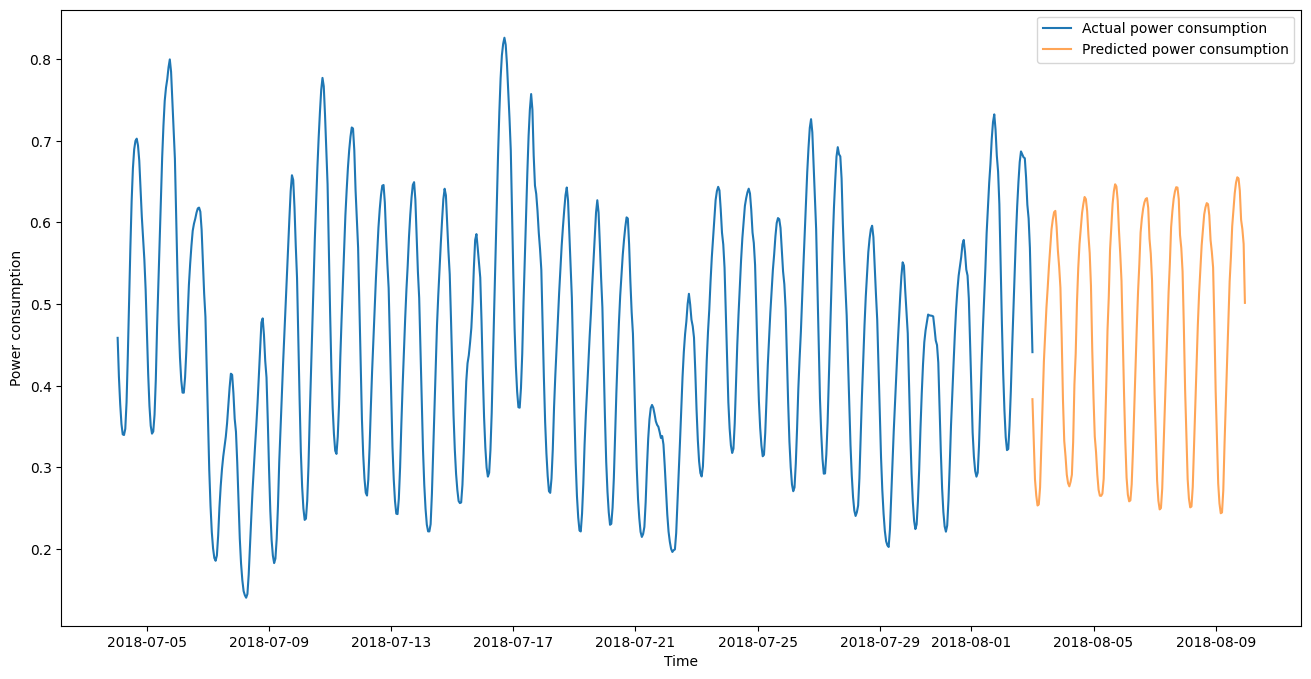

In [77]:
future_df = create_future_days_data(start_date, period)
future_prediction = rf.predict(future_df)
future_df["Power_Demand"] = future_prediction
plot_predictions(y_test.iloc[-24*30:], future_df["Power_Demand"])

### 3- LSTM :

In [49]:
lstm_future_days = np.array(data["Power_Demand"][-window_len:])

for i in range(168):
    x = np.reshape(lstm_future_days[i: i+window_len], (1, window_len, 1))
    predicted = lstm_model.predict(x, verbose=0)
    lstm_future_days = np.append(lstm_future_days, predicted)

1/1 [==============================] - 0s 38ms/step


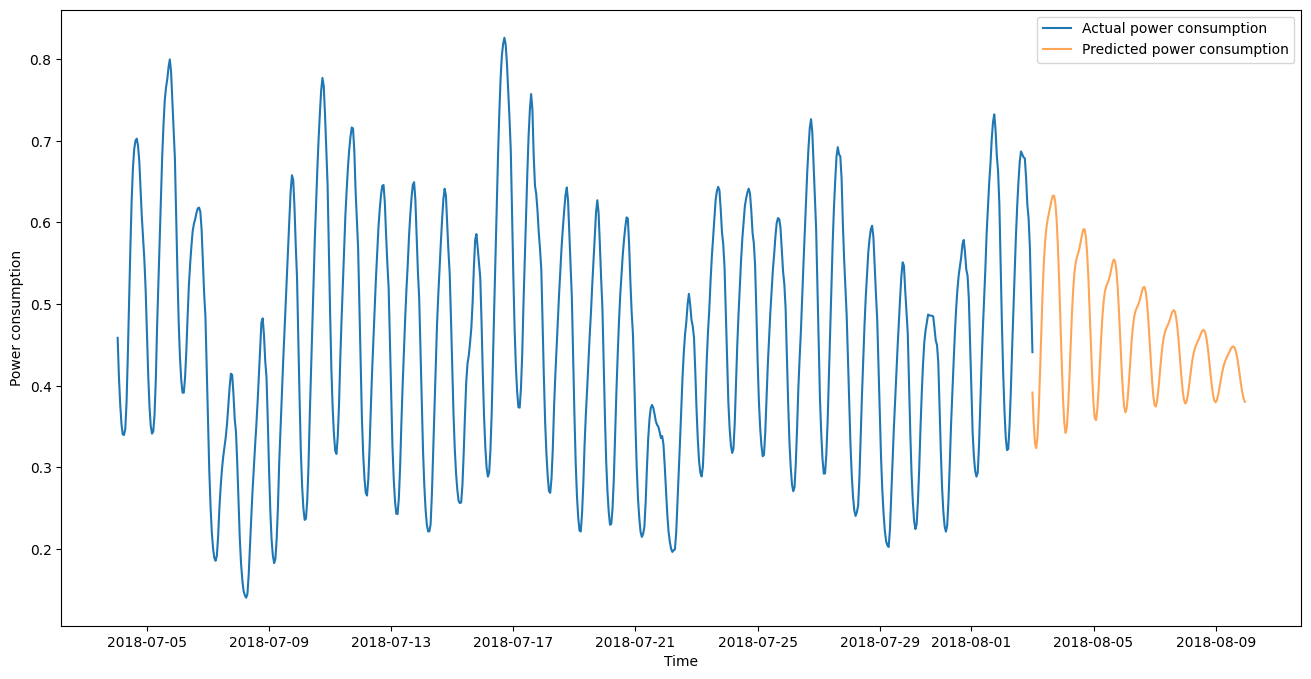

In [60]:
future_df = create_future_days_data(start_date, period)
future_df["Power_Demand"] = lstm_future_days[window_len:]
plot_predictions(y_test.iloc[-24*30:], future_df["Power_Demand"])

What do these results and plots tell us ?

* The LSTM model outperforms the XGBoost and Random Forest models in terms of accuracy metrics, a fact evident in the power consumption plots. 

* When it comes to predicting power consumption for the next seven days, the LSTM model exhibits less favorable outcomes, with its predicted values appearing to stabilize around a constant value. This phenomenon can be attributed to the model's reliance on its own predictions to generate new forecasts.

* While the XGBoost and Random Forest models provide somewhat reasonable predictions for the next seven days (though not flawless), both exhibit results that follow a sinusoidal pattern, which deviates from the actual power consumption trend.

## Conculsion

For this power consumption forecast task, we tried to build three prediction models and after exploring the data and going through all the models training and testing steps, we have arrived at the following key findings :

1- LSTM models demonstrated superior accuracy in their predictions. However, they fell short in providing robust forecasts for future consumption trends.

2- On the contrary, the two machine learning models yielded subpar accuracy results but displayed a more reasonable ability to predict power consumption for the upcoming seven days.

3- It is worth noting that the results obtained in this study can be further enhanced by fine-tuning the models' hyperparameters. Nonetheless, to create an exceptionally accurate power consumption forecasting model, the incorporation of additional input features, such as weather data, will be essential.